# Using SMAC to optimize hyperparameters of RF

* Installation of SMAC
* Defintion of function to be optimized (RF on Boston Dataset)
* Definition of RF's configspace
* Definition of SMAC's scenario
* Running SMAC

## Installation of SMAC and its Dependencies

In [33]:
!apt-get install swig -y
!pip install Cython
!pip install pyrfr==0.8.0 --no-cache --user
# hack to find pyrfr
import sys
import logging

sys.path.insert(0,"./.local/lib/python3.6/site-packages")

!pip install git+https://github.com/automl/SMAC3.git@development

logging.basicConfig(level=logging.INFO)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.10-1.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
  Cloning https://github.com/automl/SMAC3.git (to revision development) to /tmp/pip-req-build-p2ogp2fe
  Running setup.py bdist_wheel for smac ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-lhetxl4y/wheels/f4/8d/4f/2ba4cb80693f139ea06c2e8541e012a93738fb56bc1e43a202
Successfully built smac


## Installing Pep8

In [34]:
!pip install pycodestyle
!pip install pycodestyle_magic
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


## Optimize RF RMSE performance on Boston Dataset

In [0]:
# %%pycodestyle

from sklearn.metrics import make_scorer
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.datasets import load_iris
import numpy as np


iris = load_iris()


def rf_from_cfg(cfg, seed):
    """
        Creates a random forest regressor from sklearn and fits the given data on it.
        This is the function-call we try to optimize. Chosen values are stored in
        the configuration (cfg).

        Parameters:
        -----------
        cfg: Configuration
            configuration chosen by smac
        seed: int or RandomState
            used to initialize the rf's random generator

        Returns:
        -----------
        np.mean(rmses): float
            mean of root mean square errors of random-forest test predictions
            per cv-fold
    """
    # Following from the SMAC documentation example for SVM's

    # For deactivated parameters, the configuration stores None-values.
    # This is not accepted by the SVM, so we remove them.
    cfg = {k: cfg[k] for k in cfg if cfg[k]}

    # We translate boolean values:
    cfg["shrinking"] = True if cfg["shrinking"] == "true" else False

    clf = SVC(**cfg, random_state=42)

    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
    return 1-np.mean(scores)  # Minimize!

## Define Configuration Space

In [36]:
# %%pycodestyle

from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import CategoricalHyperparameter, \
    UniformFloatHyperparameter, UniformIntegerHyperparameter
from ConfigSpace.conditions import InCondition

cs = ConfigurationSpace()

c = UniformFloatHyperparameter("C", 0.001, 1000.0, default_value=1.0)
kernel = CategoricalHyperparameter("kernel", ["linear", "poly", "rbf", "sigmoid", "precomputed"], default_value="rbf")
shrinking = CategoricalHyperparameter("shrinking", ["true", "false"], default_value="true")
degree = UniformIntegerHyperparameter("degree", 1, 5, default_value=3)
coef0 = UniformFloatHyperparameter("coef0", 0.0, 10.0, default_value=0.0)
gamma = UniformFloatHyperparameter("gamma", 0.0001, 8.0, default_value=1.0)

con1 = InCondition(child=degree, parent=kernel, values=["poly"])
con2 = InCondition(child=gamma, parent=kernel, values=["poly", "rbf", "sigmoid"])
con3 = InCondition(child=coef0, parent=kernel, values=["poly", "sigmoid"])

cs.add_hyperparameters([c, kernel, shrinking, degree, coef0, gamma])
cs.add_conditions([con1, con2, con3])

print(cs)

Configuration space object:
  Hyperparameters:
    C, Type: UniformFloat, Range: [0.001, 1000.0], Default: 1.0
    coef0, Type: UniformFloat, Range: [0.0, 10.0], Default: 0.0
    degree, Type: UniformInteger, Range: [1, 5], Default: 3
    gamma, Type: UniformFloat, Range: [0.0001, 8.0], Default: 1.0
    kernel, Type: Categorical, Choices: {linear, poly, rbf, sigmoid, precomputed}, Default: rbf
    shrinking, Type: Categorical, Choices: {true, false}, Default: true
  Conditions:
    coef0 | kernel in {'poly', 'sigmoid'}
    degree | kernel in {'poly'}
    gamma | kernel in {'poly', 'rbf', 'sigmoid'}



## Define Scenario

In [37]:
# %%pycodestyle

from smac.scenario.scenario import Scenario

scenario = Scenario({"run_obj": "quality",   # we optimize quality (alternative runtime)
                     "cs": cs,               # configuration space
                     "deterministic": "true",
                     "memory_limit": 3072,   # adapt this to reasonable value for your hardware
                     "output_dir": ".",       # deactivate output
                     "runcount_limit": 200,  # number of function evaluations
                     })

INFO:smac.scenario.scenario.Scenario:Output to .


## Run SMAC

In [38]:
# %%pycodestyle

from smac.facade.smac_facade import SMAC

smac_list = []

run_smac_num = 10

for i in range(0, run_smac_num):
    smac = SMAC(scenario=scenario, rng=np.random.RandomState(42 + i),
                tae_runner=rf_from_cfg)

    incumbent = smac.optimize()
    smac_list.append(smac)

INFO:smac.facade.smac_facade.SMAC:Optimizing a deterministic scenario for quality without a tuner timeout - will make SMAC deterministic!
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklear

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

INFO:smac.intensification.intensification.Intensifier:  C : 1.0 -> 5.597350022193619
INFO:smac.intensification.intensification.Intensifier:  coef0 : None -> 0.5942617801863076
INFO:smac.intensification.intensification.Intensifier:  degree : None -> 1
INFO:smac.intensification.intensification.Intensifier:  gamma : 1.0 -> 1.365427367362704
INFO:smac.intensification.intensification.Intensifier:  kernel : 'rbf' -> 'poly'
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intens

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.i

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.in

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/d

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
 

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__


  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py"

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.intensification.intensification.Intens

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_c

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError

  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__


  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/d

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
  

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.i

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pyn

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.i

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, i

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intens

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intens

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
  

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.in

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.i

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__


INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function ca

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pyni

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

INFO:smac.intensification.intensification.Intensifier:  C : 7.075137003139163 -> 12.251594556310556
INFO:smac.intensification.intensification.Intensifier:  gamma : None -> 0.02823601219701072
INFO:smac.intensification.intensification.Intensifier:  kernel : 'linear' -> 'rbf'
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multi

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/

ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.stats.stats.Stats:Statistics:
INFO:smac.stats.stats.Stats:#Incumbent changed: 2
INFO:smac.stats.stats.Stats:#Target algorithm runs: 200 / 200.0
INFO:smac.stats.stats.Stats:#Configurations: 199
INFO:smac.stats.stats.Stats:Used wallclock time: 101.29 / inf sec 
INFO:smac.stats.stats.Stats:Used target algorithm runtime: 13.03 / inf sec
INFO:smac.stats.stats.Stats:##########################################################
INFO:smac.facade.smac_facade.SMAC:Final Incumbent: Configuration:
  C, Value: 12.251594556310556
  gamma, Value: 0.02823601219701072
  kernel, Value: 'rbf'
  shrinking, Value: 'true'

INFO:smac.facade.smac_facade.SMAC:

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
  

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensifi

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-

INFO:smac.intensification.intensification.Intensifier:Challenger (0.0133) is better than incumbent (0.0200) on 1 runs.
INFO:smac.intensification.intensification.Intensifier:Changes in incumbent:
INFO:smac.intensification.intensification.Intensifier:  C : 0.13764377345169174 -> 1.6645393098044046
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d3

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pyni

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__


  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.i

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most 

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File 

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
  

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_c

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
INFO:smac.in

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/d

  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/d

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/pytho

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/jobl

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
 

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
INFO:smac.intensification.in

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0267
INFO:smac.i

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File 

  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_as

  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__


  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 588, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 111, in apply_async
    result = ImmediateResult(func)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/_parallel_backends.py", line 332, in __init__
    self.results = batch()
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/ex

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.in

  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in __call__
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 131, in <listcomp>
    return [func(*args, **kwargs) for func, args, kwargs in self.items]
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0333
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cr

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.in

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py

ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dis

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_c

  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1668, in _fit_and_score
    X_train, y_train = _safe_split(estimator, X, y, train)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1730, in _safe_split
    raise ValueError("X should be a square kernel matrix")
ValueError: X should be a square kernel matrix
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0200
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multi

INFO:smac.intensification.intensification.Intensifier:Updated estimated cost of incumbent on 1 runs: 0.0133
Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.6/d

Process pynisher function call:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/pynisher/limit_function_call.py", line 83, in subprocess_func
    return_value = ((func(*args, **kwargs), 0))
  File "<ipython-input-35-b3d389224374>", line 43, in rf_from_cfg
    scores = cross_val_score(clf, iris.data, iris.target, cv=5)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py", line 1581, in cross_val_score
    for train, test in cv)
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 779, in __call__
    while self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/parallel.py", line 625, in dispatch_one_batch
    self._dispatch(tasks)
  

### Get Data

In [0]:
# %%pycodestyle

def get_data(smac):

    data = []

    for element in smac:
        # get runhistory, all runs ever evaluated by smac
        runhistory = element.get_runhistory()

        # extract x value and corresponding y value
        x_smac = []
        y_smac = []
        for entry in runhistory.data:  # iterate over data because it is an OrderedDict
            config_id = entry.config_id  # look up config id
            config = runhistory.ids_config[config_id]  # look up config
            y_ = runhistory.get_cost(config)  # get cost
            x_ = config["x1"]  # there is only one entry in our example
            x_smac.append(x_)
            y_smac.append(y_)
        x_smac = np.array(x_smac)
        y_smac = np.array(y_smac)
        data.append(y_smac)
    return data

### Plot function

In [0]:
# %%pycodestyle

from matplotlib import mlab
from matplotlib import pyplot as plt


def plot_performance(smac_list, MAX_FUN, fig, color, color_face):

    median2 = []
    first_quartel = []
    second_quartel = []
    data = get_data(smac_list)

    med_of_eval = []

    for j in range(0, MAX_FUN):

        for i in range(0, len(data)):
            med_of_eval.append(data[i][j])

        med_of_eval.sort()
        a, b, c = mlab.prctile(med_of_eval, p=(25.0, 50.0, 75.0))
        median2.append(b)
        first_quartel.append(a)
        second_quartel.append(c)

    # print(first_quartel)
    # print(median2)
    # print(second_quartel)

    ax = fig.add_subplot(111)

    # Plotting
    plt.plot(median2, 'o', color=color)
    ax.fill_between(range(0, MAX_FUN), first_quartel,
                    second_quartel, alpha=0.5, facecolor=color_face, interpolate=True)

    plt.xlabel('function evaluation')
    plt.ylabel('loss')
    plt.xscale('log')

    plt.step(median2, 'k', where="post", color=color)  # please note that we use step function!

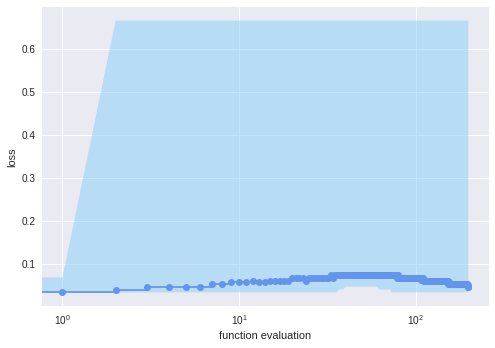

In [41]:
# %%pycodestyle

fig = plt.figure()
plot_performance(smac_list, 200, fig, 'cornflowerblue', 'lightskyblue')